# FINANCIAL ENGINEERNING PROJECT 

### IMPORT ALL NECESSARY PACKAGES FOR ANALYSIS

In [1]:
import textblob
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import re
import matplotlib.dates as dates
import datetime
from datetime import date, timedelta , datetime, time
import seaborn as sns
import yfinance as yf
from scipy import stats
import scipy.optimize as sco


## Set plot size as desired
%matplotlib inline
rcParams['figure.figsize'] = 12, 6

## PHASE A: CAPM

### DEFINE ALL NECESSARY METHODS REQUIRED FOR CAPM

In [2]:
## DEFINE METHOD TO EXTRACT PRICE DATA, PLOT IT AND GENERATE THE CAPITAL ASSET PRICING MODEL (CAPM) ON IT
def capm(stock_ticker, market_ticker, riskfree_ticker, start_date, end_date):
    #Using Yahoo finance, get daily price data within specified range and risk free rate
    daily_stock = yf.Ticker(stock_ticker).history(period='1d', start=start_date, end=end_date)
    daily_mkt = yf.Ticker(market_ticker).history(period='1d', start=start_date, end=end_date)
    daily_rf = yf.Ticker(riskfree_ticker).history(period='1d', start=start_date, end=end_date)
    
    dailyReturn = np.log((daily_stock.Close/(daily_stock.Close).shift(1)))
    averageReturn = dailyReturn.mean() * 252
    averageVolatility = np.sqrt(dailyReturn.var() * 252)
    
    ## convert these daily data to momthly by taking the close price on the final day of each month
    monthly_stock = daily_stock.resample('M').last()
    monthly_mkt = daily_mkt.resample('M').last()
    monthly_rf = daily_rf.resample('M').last()
    
    ## plot the stock price and moving averages for analysis
    close = daily_stock.Close
    ma20 = daily_stock.Close.rolling(20).mean()
    ma200 = daily_stock.Close.rolling(200).mean()
    plt.plot(close, label='Close')
    plt.plot(ma20, label = 'ma20')
    plt.plot(ma200, label = 'ma200')
    plt.title(stock_ticker + ' price with short and long term moving averages'.upper(), fontsize=18)
    plt.xlabel('Date', fontsize=15)
    plt.ylabel('Closing price', fontsize=15)
    plt.legend()
    plt.grid()
    plt.show()
    
    ## calculate monthly return for individual stock and market
    monthly_stock_return = ((monthly_stock['Close']/monthly_stock['Close'].shift(1))-1).dropna()
    monthly_mkt_return = ((monthly_mkt['Close']/monthly_mkt['Close'].shift(1))-1).dropna()
    
    ## estimate market returns - risk free rate and stock returns - risk free rate
    ## to be use to compute Beta through a time series regression
    rm_rf = monthly_mkt_return - monthly_rf.Close[1:]/100
    ri_rf = monthly_stock_return - monthly_rf.Close[1:]/100

    ## Linear regression used to obtain alpha and beta
    slope, intercept, r_value, p_value, std_err = stats.linregress(rm_rf, ri_rf)
    alpha = intercept
    beta = slope

    ## calulate linear fit for plotting
    linfit = alpha + beta*rm_rf

    ## plot time series data and resulting regression fit
    plt.scatter(rm_rf, ri_rf, label='Monthly data')
    plt.plot(rm_rf, linfit, 'r', label='Linear Regression')
    plt.title(stock_ticker +' MONTHLY TIME SERIES REGRESSION TO OBTAIN BETA', fontsize=18)
    plt.xlabel('Rm - rf', fontsize=15)
    plt.ylabel('Ri - rf', fontsize=15)
    plt.legend()
    plt.grid()
    plt.show()
    
    ## Display results of regression
    print('alpha, Beta, R-squared:')
    print(round(alpha, 3), round(beta, 3), round(r_value**2, 3))
    
    return [alpha, beta, r_value**2, averageReturn, averageVolatility]

### RUN CAPM FOR ALL STOCKS / CRYPTO OF INTEREST

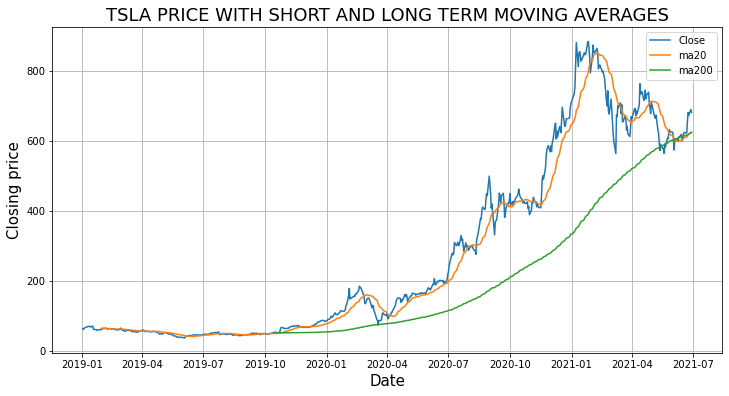

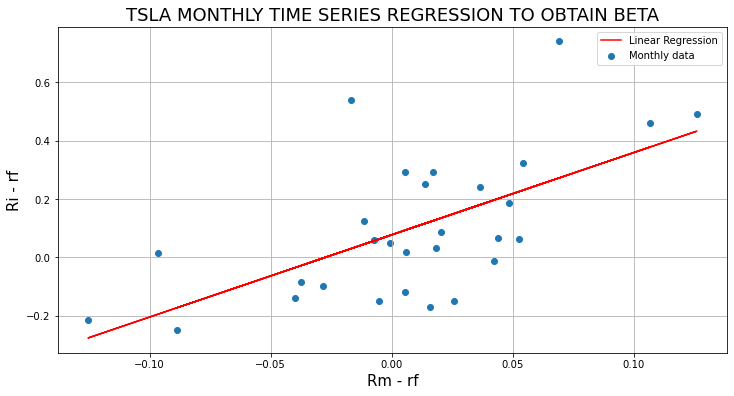

alpha, Beta, R-squared:
0.078 2.82 0.386


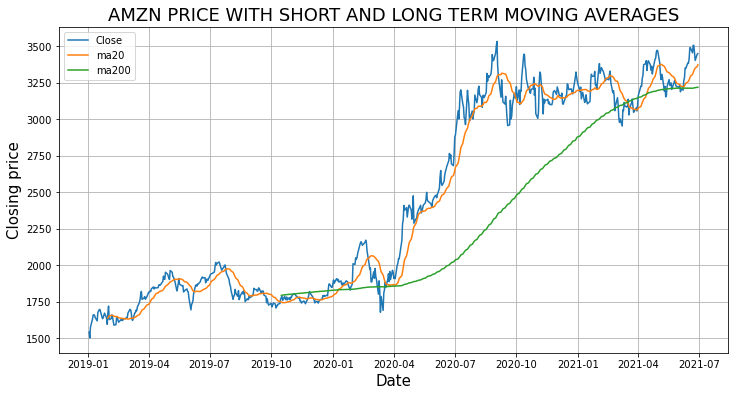

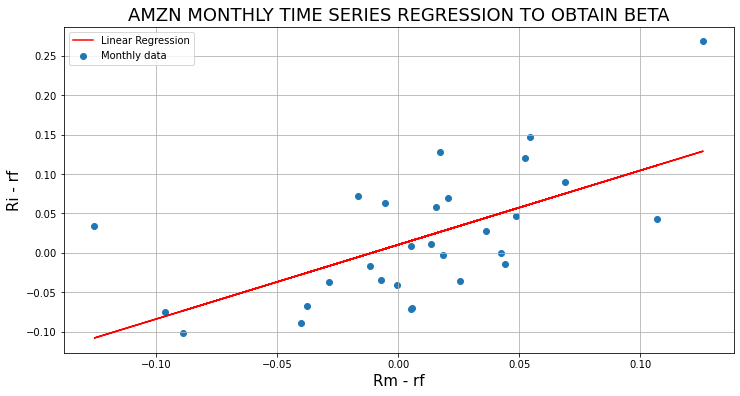

alpha, Beta, R-squared:
0.01 0.942 0.385


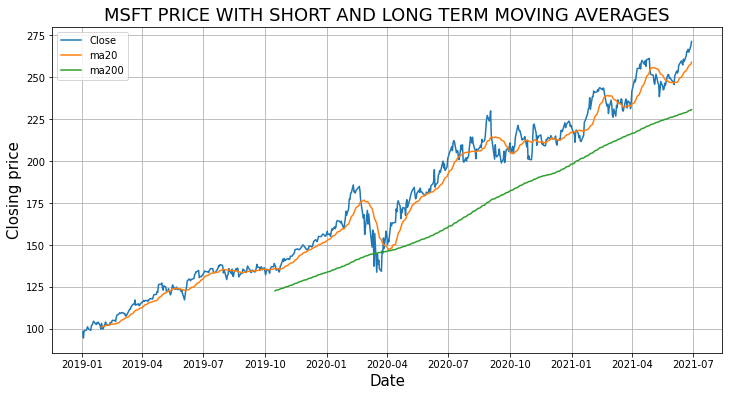

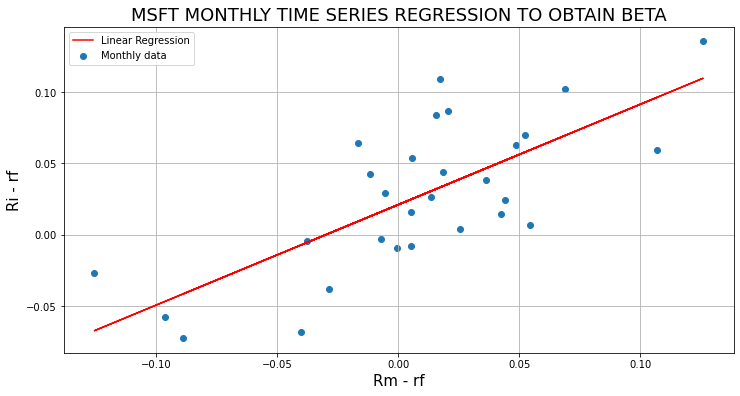

alpha, Beta, R-squared:
0.021 0.704 0.532


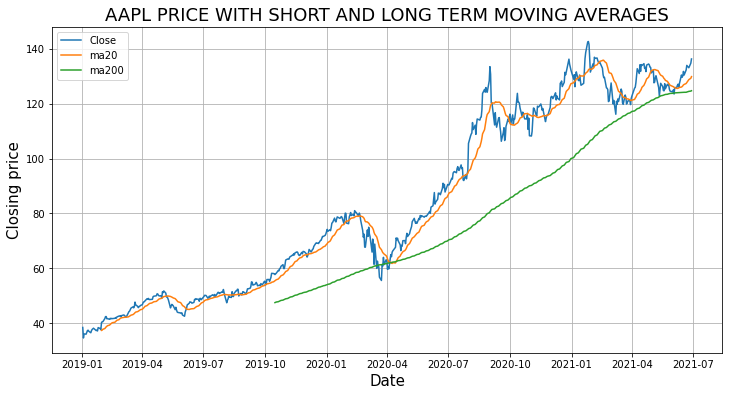

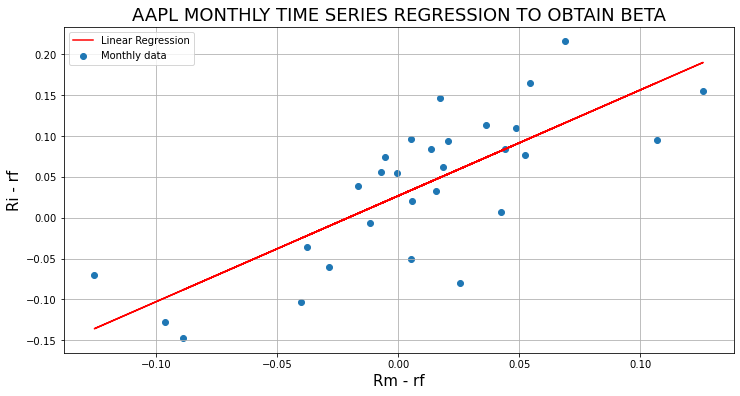

alpha, Beta, R-squared:
0.027 1.296 0.589


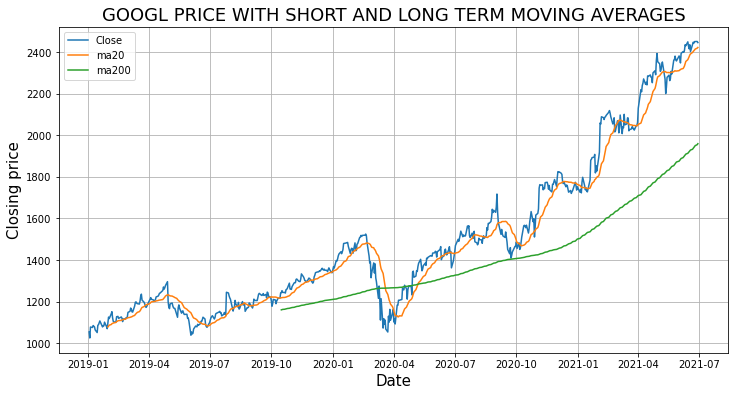

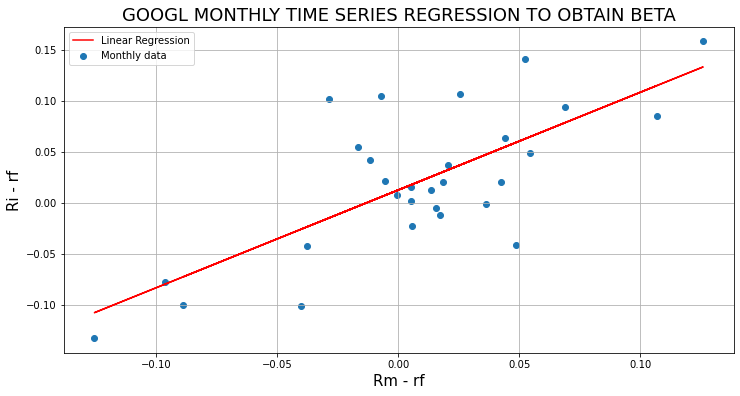

alpha, Beta, R-squared:
0.012 0.959 0.528


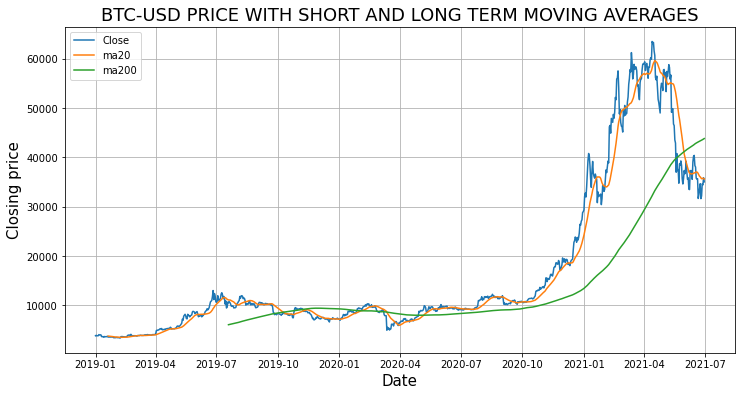

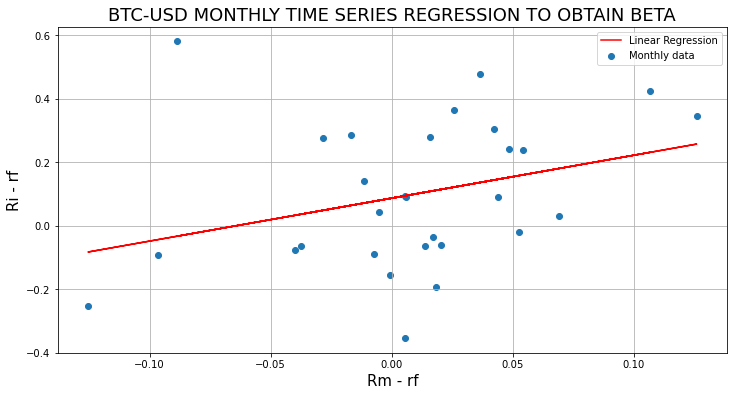

alpha, Beta, R-squared:
0.086 1.352 0.101


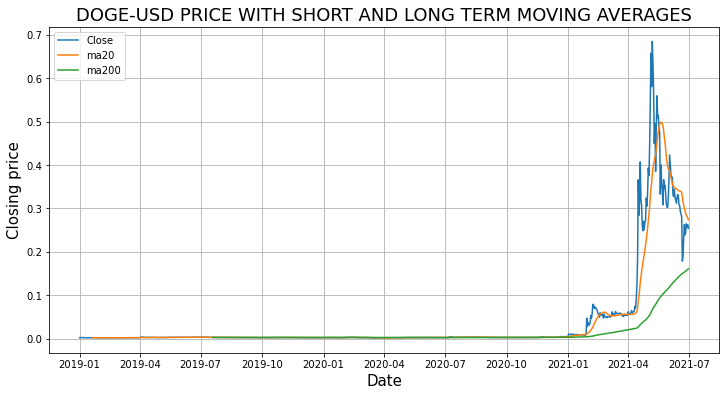

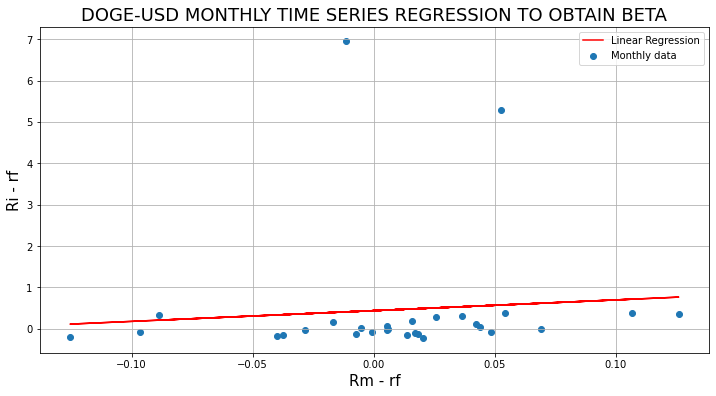

alpha, Beta, R-squared:
0.44 2.595 0.008


In [3]:
## Project involves combining stocks and crypto hence all portfolios will be analyzed
Stocks = ['TSLA', 'AMZN', 'MSFT', 'AAPL', 'GOOGL', 'BTC-USD', 'DOGE-USD']
# Stocks = ['DOGE-USD']


## get current date to start analysis
today = str(date.today())

sticker = []
alpha = []
beta = []
rsquared = []
Avgreturn = []
Avgrisk = []
## Loop through stocks and crypto list and perform CAPM for each one 
for stock in Stocks:
    solution = capm(stock, '^GSPC', '^IRX', '2019-1-1', '2021-06-30')
    alpha.append(solution[0])
    beta.append(solution[1])
    rsquared.append(solution[2])
    Avgreturn.append(solution[3])
    Avgrisk.append(solution[4])
    sticker.append(stock)

result_df = pd.DataFrame()
result_df['Stock'] = sticker
result_df['Alpha'] =  alpha
result_df['Beta'] =  beta
result_df['Rsquared'] = rsquared
result_df['Expected Return'] = Avgreturn
result_df['Risk'] = Avgrisk

### SAVE RESULTS FOR FURTHER ANALYSIS

In [4]:
#save results to filepath
writer = pd.ExcelWriter('Stocks Comparison T.xlsx', engine='xlsxwriter')
result_df.to_excel(writer, sheet_name='Sheet1')
writer.save()

## PHASE B: SENTIMENT ANALYSIS

### DECLARE TWITTER API KEYS, INITIATE TWEEPY API 

#### NOTE: FREE API HAS 7 DAY LIMIT TWITTER QUERY LIMIT

In [5]:
## Twitter API keys 
## All keys are left blank, usere is required to generate personal keys from developer.twitter.com
api_key = ''
api_key_secret = ''
access_token = ''
access_token_secret = ''



## create a tweepy authenticator to access twitter using the keys
authenticator = tweepy.OAuthHandler(api_key, api_key_secret)
authenticator.set_access_token(access_token, access_token_secret)
api = tweepy.API(authenticator, wait_on_rate_limit=True)

### DEFINE ALL NECESSARY METHODS FOR SENTIMENT ANALYSIS

In [6]:
## This method extracts tweets from twitter using tweetpy and analyzes the 
## text using textblob text NLP. The positive, negative and neutral sentiments are returned
def SentimentAnalysis(api_key, api_key_secret, access_token, access_token_secret, 
                      keyword, start_date, end_date, n_tweets, search_type='dated'):
    ## create a tweepy authenticator to access twitter using the keys
    authenticator = tweepy.OAuthHandler(api_key, api_key_secret)
    authenticator.set_access_token(access_token, access_token_secret)
    api = tweepy.API(authenticator, wait_on_rate_limit=True)
    
    ## select topic you want to search tweets on
    crypto_currency = keyword

    start = start_date
    end = end_date
    
    ## create a cursor to search for tweets, set languages as required and set number of tweets to scrape
    search = f'#{crypto_currency} -filter:retweets'
    if search_type == 'dated':
        tweet_cursor = tweepy.Cursor(api.search, q=search, lang='en', 
                                     until=end, since=start, tweet_mode='extended').items(n_tweets)
    elif search_type == 'ndated':
        tweet_cursor = tweepy.Cursor(api.search, q=search, lang='en', tweet_mode='extended').items(n_tweets)
    
    ## store search tweets in list first the convert to dataframe
    tweets = [tweet.full_text for tweet in tweet_cursor]
    tweets_df = pd.DataFrame(tweets, columns=['Tweets'])
    
    ## iterate through rows and delete unneccesary items from scraped tweets such as websites,
    ## hastags, mentions etc. The removal process means we replace it with an empty string
    for i, row in tweets_df.iterrows():
        row['Tweets'] = re.sub('http\S+', '', row['Tweets'])
        row['Tweets'] = re.sub('#\S+', '', row['Tweets'])
        row['Tweets'] = re.sub('@\S+', '', row['Tweets'])
        row['Tweets'] = re.sub('\\n', '', row['Tweets'])
        
    ## map a new column to the dataframe named polarity.  The column is called by the lambda function 
    ## and used to invoke NLP text analysis on TextBlob
    tweets_df['Polarity'] = tweets_df['Tweets'].map(lambda tweet: textblob.TextBlob(tweet).sentiment.polarity)
    
    
    ## map a new column (results) that shows if polarity was negative or postive
    ## only using positive or negative here because of decision making but when pol is 0 it should be neutral
    ## this means tweet does not speak negatively or positively about topic, it was just mentioned
    tweets_df['Result'] = tweets_df['Polarity'].map(lambda pol: '+' if pol > 0 else ('n' if pol == 0 else '-'))
    
    positive = tweets_df[tweets_df.Result == '+'].count()['Tweets']
    negative = tweets_df[tweets_df.Result == '-'].count()['Tweets']
    neutral = tweets_df[tweets_df.Result == 'n'].count()['Tweets']

    return [positive, negative, neutral]


## This method calculates a sentiment index used to qualify how positive, negative or neutral 
## the perception is aboout the searched item
def SentimentIndex(pos_neg_neu, method=0): ## there are 2 methods defined below but the first has been set as default
    ## extract the pos, neg and neu number of tweets
    positive = pos_neg_neu[0]
    negative = pos_neg_neu[1]
    neutral = pos_neg_neu[2]
    
    ## method 0 considers neutral independent of negative and method 1 lumps negative and netural to calculate index
    ## method 0 assumes more neutral tweets as indication of fairly stable prices
    if method == 0:
        if (neutral > positive) and (neutral > negative): 
            index = 0
        else:
            posnormalized = positive / (positive + negative)
            negnormalized = negative / (positive + negative)
            index = posnormalized - negnormalized
    ## method 1 treats neutral tweets as negative and non investor friendly
    elif method == 1:
        negative = negative + neutral
        posnormalized = positive / (positive + negative)
        negnormalized = negative / (positive + negative)
        index = posnormalized - negnormalized
    
    ## method 2 completely ignores neutral tweets and compares positive and negative tweets
    ## This method is more sensitive
    elif method == 2:
        posnormalized = positive / (positive + negative)
        negnormalized = negative / (positive + negative)
        index = posnormalized - negnormalized
          
    return index

### GATHER LAST 7 DAYS SENTIMENT ANALYSIS DATA USING PRE-DEFINED METHODS

In [7]:
## get current date to start analysis
today = str(date.today())

## set topic to perform sentiment analysis on and the number of tweets to extract and analyze
search_topic = 'dogecoin'
num_of_tweets = 100

if (search_topic.lower() == 'bitcoin'):
    coin = 'BTC-USD'
else:
    coin = 'DOGE-USD'


## loop through the last 7 days (8 as last day is inclusive
## peform sentiment analysis and save results
sentiment_index = []
datelist = []
pos = []
neg = []
neu = []
for i in range(8):
    ## evaluate daily start and end dates for extraction
    present_day = str(date.today() - timedelta(days = i))
    previous_day = str(date.today() - timedelta(days = i+1))
    
    ## perform sentiment analysis by calling the method
    daily_sentiment = SentimentAnalysis(api_key, api_key_secret, access_token, access_token_secret, 
                      search_topic, previous_day, present_day, num_of_tweets)
    
    
    ## calculate sentiment index
    daily_sentiment_index = SentimentIndex(daily_sentiment, 2)
    
    ## save data in list for analysis or future reference
    pos = np.append(pos, daily_sentiment[0])
    neg = np.append(neg, daily_sentiment[1])
    neu = np.append(neu, daily_sentiment[2])
    datelist = np.append(datelist, previous_day)
    sentiment_index = np.append(sentiment_index, daily_sentiment_index)

### IMPORT CRYPTO PRICE DATA AND EVALUATE SENTIMENT INDEX

In [8]:
## get daily coin prices
coinprice = yf.Ticker(coin).history(period='1d', start=datelist[7], end=datelist[0])['Close'].values
    
    
datelist=np.flipud(datelist)
sentiment_index=np.flipud(sentiment_index)
pos = np.flipud(pos)
neg = np.flipud(neg)
neu = np.flipud(neu)

total = pos.cumsum() + neg.cumsum()
newindex = (pos.cumsum()/total) - (neg.cumsum()/total)
newindex

## ADJUST INDEX FORWARD
newnew = [0] ## random mumber to be removed
for i in newindex:
    newnew.append(i)
newnew = np.array(newnew)
newnew = newnew[0:8]

### VISUALIZE RESULTS OF SENTIMENT ANALYSIS

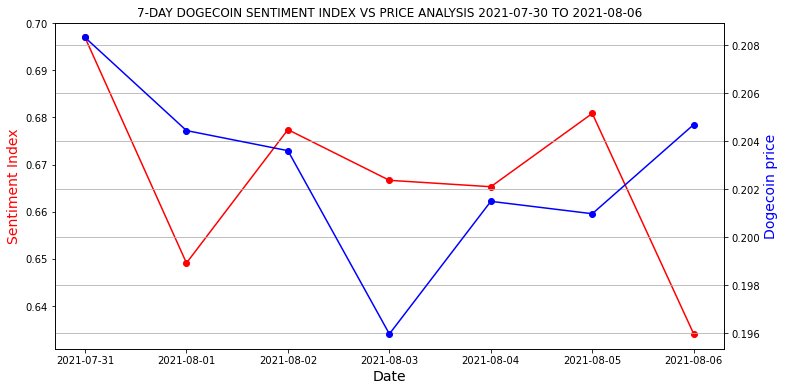

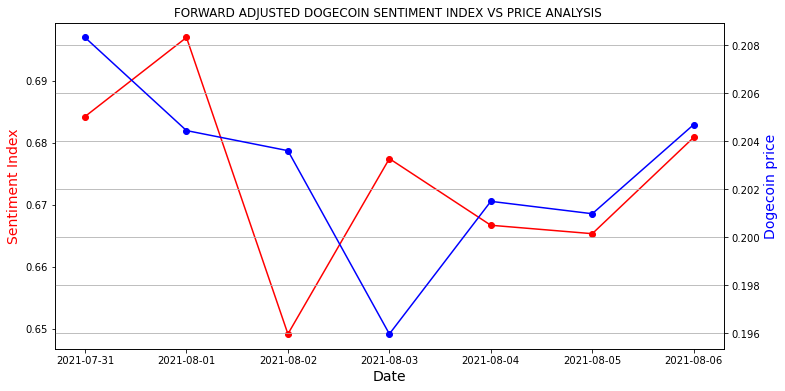

In [9]:
## ORIGINAL PLOT OF PRICE AND SENTIMENT
fig,ax = plt.subplots()
ax.plot(datelist[1:], newindex[1:], color ='red', label ='Sentiment Index', marker='o')
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Sentiment Index",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(datelist[1:], coinprice[1:], color ='blue', label ='Bitcoin Price', marker='o')
ax2.set_ylabel(search_topic.capitalize() + ' price',color="blue",fontsize=14)
plt.title('7-DAY ' + search_topic.upper() + ' SENTIMENT INDEX VS PRICE ANALYSIS ' + datelist[0] + ' TO ' + datelist[7])
plt.grid()
plt.show()




## FOREWORD ADJUSTED SENTIMENT TO MATCH PRICE
fig,ax = plt.subplots()
ax.plot(datelist[1:], newnew[1:], color ='red', label ='Sentiment Index', marker='o')
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Sentiment Index",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(datelist[1:], coinprice[1:], color ='blue', label ='Bitcoin Price', marker='o')
ax2.set_ylabel(search_topic.capitalize() + ' price',color="blue",fontsize=14)
plt.title('FORWARD ADJUSTED ' + search_topic.upper() + ' SENTIMENT INDEX VS PRICE ANALYSIS ')
plt.grid()
plt.show()

### SAVE DATA FOR CONTINOUS MONITORING

In [10]:
datelist_df = pd.DataFrame(datelist, columns=['DATE'])
pos_df = pd.DataFrame(pos, columns=['POSITIVE'])
neg_df = pd.DataFrame(neg, columns=['NEGATIVE'])
neu_df = pd.DataFrame(neu, columns=['NEUTRAL'])
sentiment_index_df = pd.DataFrame(sentiment_index, columns=['SENTIMENT INDEX'])

result = pd.concat([datelist_df, pos_df, neg_df, neu_df, sentiment_index_df], axis=1)

#save results to filepath
name = input('save results as: ')
writer = pd.ExcelWriter(name + ' ' + datelist[0] + ' Sentiment Analysis.xlsx', engine='xlsxwriter')
result.to_excel(writer, sheet_name='Sheet1')
writer.save()

save results as: Dogecoin Most Recent


## PHASE C: PORTFOLIO OPTIMIZATION

### DEFINE ALL NECESSARY METHODS FOR PORTFOLIO OPTIMIZATION

In [11]:
def generate_ptfs(returns, rf, N):
    ptf_rs = []
    ptf_vol = []
    for i in range(N):
        weights = np.random.random(len(returns.columns))
        weights /= np.sum(weights)
        ptf_rs.append(np.sum(returns.mean() * weights) * 252)
        ptf_vol.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights))))
    ptf_rs = np.array(ptf_rs)
    ptf_vol = np.array(ptf_vol)
    ptf_sharpe = ((ptf_rs - rf) / ptf_vol)
    
    # Plot the N randomly generated portfolio returns and volatilities and colormark the respective Sharpe ratios
    plt.scatter(ptf_vol, ptf_rs, c=ptf_sharpe, marker='o')
    plt.grid(True)
    plt.xlabel('Risk')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.title( str(N) + ' Randomly Generated Portfolios In The Risk-Return Space')
    plt.show()
    
    return ptf_rs, ptf_vol, ptf_sharpe


# Define a function that returns the portfolio statistics
def ptf_stats(weights, returns, rf):
    weights = np.array(weights)
    ptf_r = np.sum(returns.mean() * weights) * 252
    ptf_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    ptf_sharpe = (ptf_r - rf) / ptf_vol
    return np.array([ptf_r, ptf_vol, ptf_sharpe])


def min_sharpe(x, dailyReturn, avgrf):
    return -ptf_stats(x, dailyReturn, avgrf)[2]



def maximize_sharpe(stocks, dailyReturn, avgrf):
    # Write the constraint that the weights have to add up to 1
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # Bound the weights (parameter inputs) to be within 0 and 1
    bnds = tuple((0, 1) for x in range(len(stocks)))
    
    # Starting parameter (weights) list as equal distribution
    starting_ws = len(stocks) * [1. / len(stocks),]
    
    # Call the minimisation function
    opts = sco.minimize(fun=min_sharpe, x0=starting_ws, args = (dailyReturn, avgrf),
                        method='SLSQP', bounds=bnds, constraints=cons)
    opts

    # Obtain the optimal weights
    weights_opt = opts['x'].round(3)
    weights_opt
    
    return weights_opt

def printOptimalResults(dailyReturn, avgrf, pvol, preturns, psharpe):
    optimized_weights = maximize_sharpe(Stocks, dailyReturn, avgrf)
    count = 0
    for i in Stocks:
        print(i + ' Opt Weight:', optimized_weights[count])
        count += 1
    optimized_port = ptf_stats(optimized_weights, dailyReturn, avgrf)
    testrisk = np.array([0, pvol.max()])
    testreturn = optimized_port[2]*testrisk + avgrf
    
    plt.plot(optimized_port[1], optimized_port[0], 'r*', markersize=15.0)
    plt.plot(testrisk,testreturn,'r', label='CML' )
    plt.scatter(pvol, preturns, c=psharpe, marker='o')
    plt.title('CAPITAL MARKET LINE (CML)')
    plt.xlabel('Risk')
    plt.ylabel('Expected Return')
    plt.colorbar(label='Sharpe Ratio')
    plt.legend()
    plt.grid()
    plt.show()
    

    print('Optimal Portfolio Returns: ', optimized_port.round(3)[0])
    print('Optimal Portfolio Risk: ', optimized_port.round(3)[1])
    print('Optimal Sharpe Ratio: ', optimized_port.round(3)[2])
    
    return optimized_weights

def MVTPortfolioOpt(Stocks, start_date, end_date, N): ## Main program
    Stock_prices = pd.DataFrame()
    for stock in Stocks:
        Stock_prices[stock] = yf.Ticker(stock).history(period='1d', start=start_date, end=end_date)['Close']
    Stock_prices.columns = Stocks

    avgrf = (yf.Ticker('^IRX').history(period='1d', start=start_date, end=end_date)['Close']/100).mean()
    avgrf

    dailyReturn = np.log((Stock_prices/Stock_prices.shift(1)))
#     dailyReturn = ((Stock_prices/Stock_prices.shift(1))-1)

    averageReturn = dailyReturn.mean() * 252
    averageVolatility = np.sqrt(dailyReturn.var() * 252)
    
    stocksummary = pd.DataFrame()
    stocksummary['Average Returns'] = averageReturn.round(3)
    stocksummary['Average Risk'] = averageVolatility.round(3)
    
    print(stocksummary)
    print()
    print('Risk-free Rate: ', round(avgrf, 3))
    
    preturns, pvol, psharpe = generate_ptfs(dailyReturn, avgrf, N)
    
    result = printOptimalResults(dailyReturn, avgrf, pvol, preturns, psharpe)
    
    return result

### PERFORM PORTFOLIO OPTIMIZATION USING THE DEFINED METHODS ABOVE

       Average Returns  Average Risk
TSLA             0.497         0.580
AMZN             0.308         0.297
MSFT             0.309         0.273
AAPL             0.315         0.300
GOOGL            0.213         0.264

Risk-free Rate:  0.011


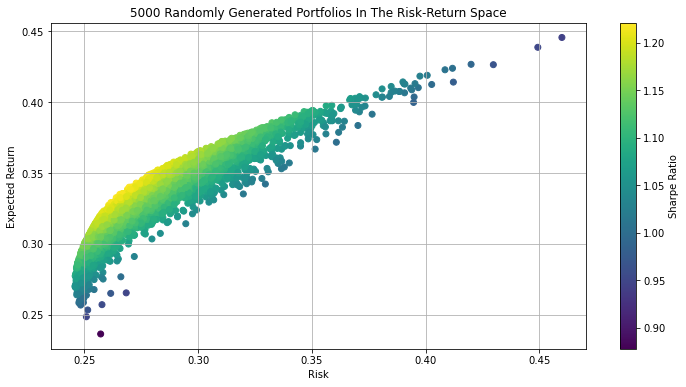

TSLA Opt Weight: 0.143
AMZN Opt Weight: 0.254
MSFT Opt Weight: 0.377
AAPL Opt Weight: 0.226
GOOGL Opt Weight: 0.0


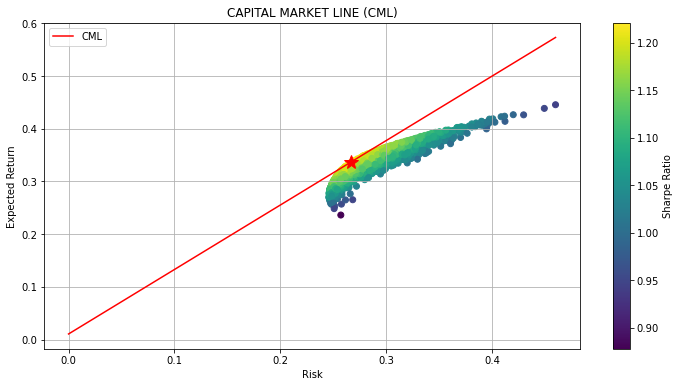

Optimal Portfolio Returns:  0.337
Optimal Portfolio Risk:  0.267
Optimal Sharpe Ratio:  1.223


In [16]:
OPT_SOLUTION = MVTPortfolioOpt(Stocks, '2016-1-1', '2021-6-30', 5000)

## PHASE D: CONTINUOUS PORTFOLIO OPTIMIZATION

### DEFINE THE ALGORITHM FOR CONTINUOUS PORTFOLIO OPTIMIZATION

In [27]:
def continuous_portfolio_OPT(topic, ntweets, interval_minutes):
    ## define current time and end time
    next_run_time = datetime.now()
    end_time_of_day = datetime.combine(date.today(), time(4, 28, 0))
    
    

    count = 1
    pos = [0]
    neg = [0]
    cont_sentiment_index = [0]
    weights = [[]]
    today = str(date.today())
    
    ## while loop keeps operation going until the end of day is reached
    while (next_run_time <= end_time_of_day):
        if datetime.now() >= end_time_of_day:
            break
        if datetime.now() >= next_run_time:
            print('Iteration: ', count)
            ## Pull tweets and calculate sentiment index for the time step
            cont_sentiment = SentimentAnalysis(api_key, api_key_secret, access_token, access_token_secret, 
                    topic, today, today, ntweets, search_type='ndated')
            pos.append(cont_sentiment[0])
            neg.append(cont_sentiment[1])
            poscum = np.cumsum(pos)[count]
            negcum = np.cumsum(neg)[count]
            total = poscum + negcum
            sentiment_index = (poscum/total) - (negcum/total)
            cont_sentiment_index.append(sentiment_index)
            
            print('Positive Sentiment: ', pos)
            print('Negative Sentiment: ',neg)
            print('Sentiment Index: ', cont_sentiment_index)
            
            ## if sentiment index calculated is lesser than previous sentiment index
            ## liquidate (sell) crypto and perform portfolio optimization on Stocks only
            ## else, Do not remove crypto, re-evaluate portfolio weights
            if cont_sentiment_index[count]< cont_sentiment_index[count-1]:
                print('CRYPTO LIQUIDATED')
                Stocks = ['TSLA', 'AMZN', 'MSFT', 'AAPL', 'GOOGL']
            else:
                Stocks = ['TSLA', 'AMZN', 'MSFT', 'AAPL', 'GOOGL', 'BTC-USD', 'DOGE-USD']
            
            
            
            ## perform portfolio optization based on sentiment based stock selection and save new weights
            ## portfolio optimzation is done with data from 1 Jan 2021 till date (can be changed)
            new_weights = MVTPortfolioOpt(Stocks, '2020-1-1', today, 1000)
            print() ## a spacer
            weights.append(new_weights)    
            
            ## increment count and next run time
            count = count + 1
            next_run_time = next_run_time + timedelta(minutes=interval_minutes)
            continue

### RUN SAMPLE CONTINUOUS PORTFOLIO OPTIMIZATION

Iteration:  1
Positive Sentiment:  [0, 14]
Negative Sentiment:  [0, 3]
Sentiment Index:  [0, 0.6470588235294117]
['TSLA', 'AMZN', 'MSFT', 'AAPL', 'GOOGL', 'BTC-USD', 'DOGE-USD']
          Average Returns  Average Risk
TSLA                1.313         0.791
AMZN                0.355         0.341
MSFT                0.379         0.371
AAPL                0.425         0.404
GOOGL               0.429         0.344
BTC-USD             1.146         0.816
DOGE-USD            2.949         2.031

Risk-free Rate:  0.003


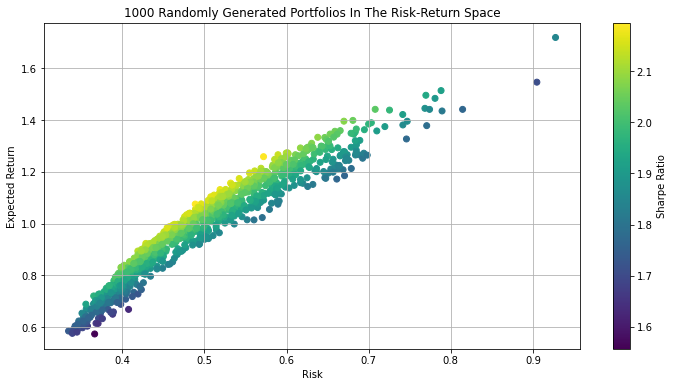

TSLA Opt Weight: 0.399
AMZN Opt Weight: 0.0
MSFT Opt Weight: 0.0
AAPL Opt Weight: 0.0
GOOGL Opt Weight: 0.328
BTC-USD Opt Weight: 0.132
DOGE-USD Opt Weight: 0.141


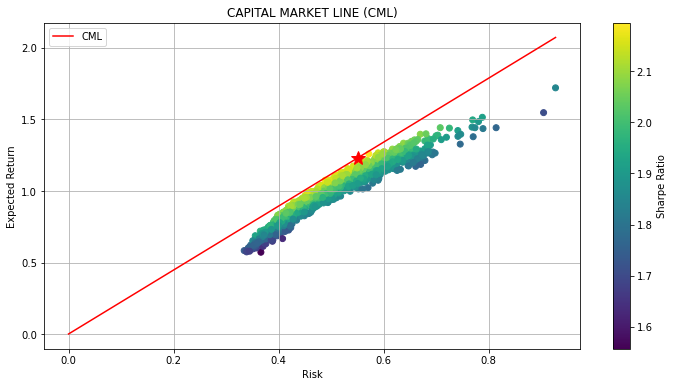

Optimal Portfolio Returns:  1.232
Optimal Portfolio Risk:  0.551
Optimal Sharpe Ratio:  2.23

Iteration:  2
Positive Sentiment:  [0, 14, 13]
Negative Sentiment:  [0, 3, 2]
Sentiment Index:  [0, 0.6470588235294117, 0.6875]
['TSLA', 'AMZN', 'MSFT', 'AAPL', 'GOOGL', 'BTC-USD', 'DOGE-USD']
          Average Returns  Average Risk
TSLA                1.313         0.791
AMZN                0.355         0.341
MSFT                0.379         0.371
AAPL                0.425         0.404
GOOGL               0.429         0.344
BTC-USD             1.146         0.816
DOGE-USD            2.949         2.031

Risk-free Rate:  0.003


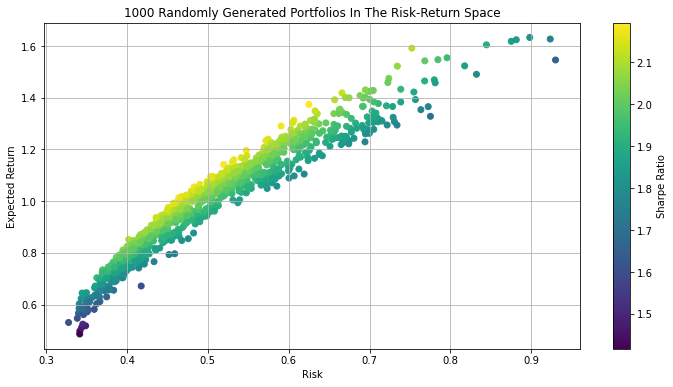

TSLA Opt Weight: 0.399
AMZN Opt Weight: 0.0
MSFT Opt Weight: 0.0
AAPL Opt Weight: 0.0
GOOGL Opt Weight: 0.328
BTC-USD Opt Weight: 0.132
DOGE-USD Opt Weight: 0.141


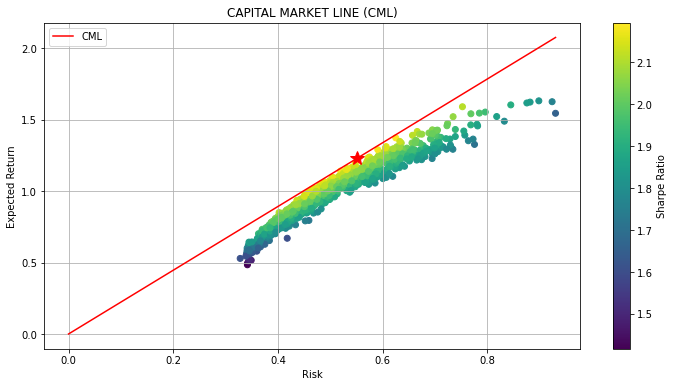

Optimal Portfolio Returns:  1.232
Optimal Portfolio Risk:  0.551
Optimal Sharpe Ratio:  2.23

Iteration:  3
Positive Sentiment:  [0, 14, 13, 16]
Negative Sentiment:  [0, 3, 2, 2]
Sentiment Index:  [0, 0.6470588235294117, 0.6875, 0.72]
['TSLA', 'AMZN', 'MSFT', 'AAPL', 'GOOGL', 'BTC-USD', 'DOGE-USD']
          Average Returns  Average Risk
TSLA                1.313         0.791
AMZN                0.355         0.341
MSFT                0.379         0.371
AAPL                0.425         0.404
GOOGL               0.429         0.344
BTC-USD             1.146         0.816
DOGE-USD            2.949         2.031

Risk-free Rate:  0.003


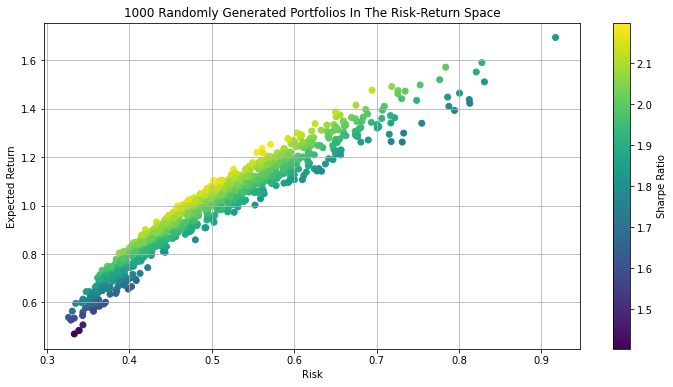

TSLA Opt Weight: 0.399
AMZN Opt Weight: 0.0
MSFT Opt Weight: 0.0
AAPL Opt Weight: 0.0
GOOGL Opt Weight: 0.328
BTC-USD Opt Weight: 0.132
DOGE-USD Opt Weight: 0.141


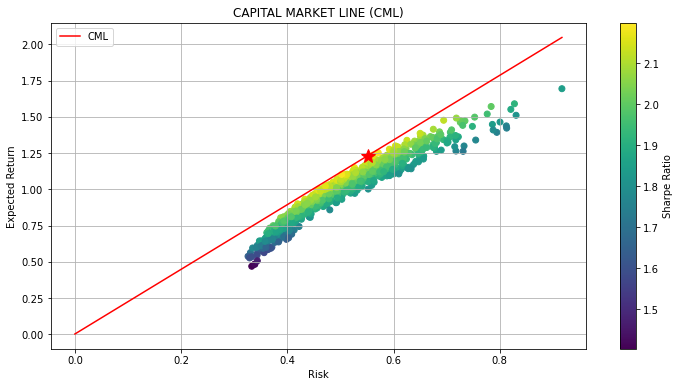

Optimal Portfolio Returns:  1.232
Optimal Portfolio Risk:  0.551
Optimal Sharpe Ratio:  2.23



In [28]:
## Take 100 tweets every minute for the next 3 minutes
continuous_portfolio_OPT('Dogecoin', 100, 1)